# [Physics 411](http://jklymak.github.io/Phy411/) Final Project
*John Coffey*


In [1]:
import matplotlib.pyplot as plt
from matplotlib import mlab, rcParams, dates
%matplotlib inline
import numpy as np
from scipy import interpolate, spatial, stats
import datetime
import scipy.signal as signal
import pandas as pd

#Load in all the data

In [2]:
# Minute data, 4 Schools
mins, dc = np.loadtxt('/Users/John/Documents/Project/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/John/Documents/Project/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/John/Documents/Project/JohnMuirNew.txt', usecols=([1]), unpack=True)
uv = np.loadtxt('/Users/John/Documents/Project/UVicISCNew.txt', usecols=([1]), unpack=True)

In [3]:
# Coast data, 
coastfile = '/Users/John/Documents/Project/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]
# Hour data, Longtitude and Latitude, 35 Stations
hourfile = '/Users/John/Documents/Project/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

In [4]:
# Make hour data
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

# First three measurements for all stations are nan, remove
data = data[:,3:]
hours = hours[3:]

#Hourly 2D Plotting

C:\Users\John\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\John\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


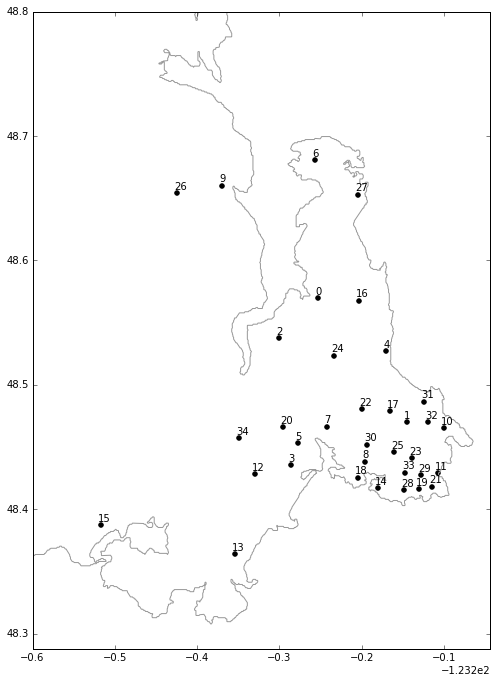

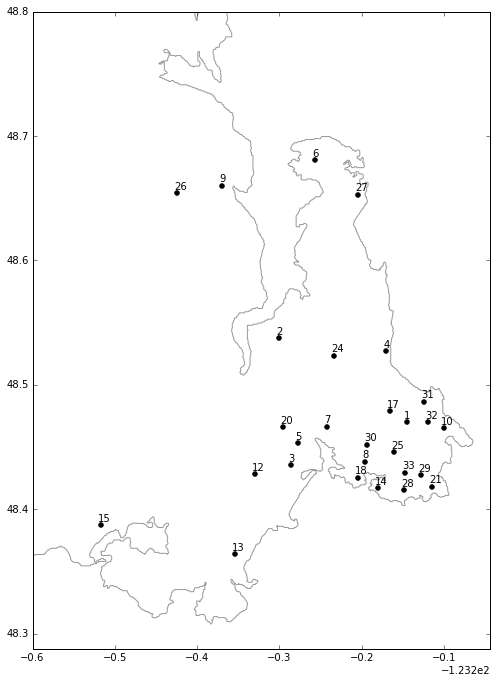

In [5]:
def station(cstlng, cstlat, lng, lat, nums = None, good = None):
    fig, ax = plt.subplots(1,1, figsize=(7,10))
    ax.plot(cstlng, cstlat, '-', color='0.6')
    
    if good is not None:
        ax.scatter(lng[good],lat[good], color='k')
    else:
        ax.scatter(lng,lat, color='k')
        
    ax.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    ax.set_ylim(np.min(cstlat)-0.02, 48.8)
    ax.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.tight_layout()
    
    labels = ['{0}'.format(i) for i in range(len(lng))]
    if nums is not None:
        for i in range(len(nums)):
            del labels[nums[-1-i]] 

    if good is not None:
        lng = lng[good]
        lat = lat[good]
        
    for label, x, y in zip(labels, lng, lat):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-2, 2),
            textcoords = 'offset points', ha = 'left', va = 'bottom')#,
#            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))#,
#            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    #return fig

good = range(1,11)+range(12,16)+range(17,19)+range(20,22)+range(24,34)
bad = [0,11,16,19,22,23,34]
station(cstlng, cstlat, lng, lat)
plt.show()
station(cstlng, cstlat, lng, lat, bad, good)
plt.show()

In [6]:
def removeStations(data,lng,lat,good):
    data = data[good,:]
    lng =lng[good]
    lat = lat[good]
    return data,lng,lat

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

def interp_nn(data, coords, tree, radius, rmean=False):
    
    # Nearest neighbour search for interpolation
    # replace value with average of neighbours
    # MAKE SURE TO ADJUST WEIGHTING TO NEAREST NEIGHBOURS **********
    # ^^^ never did but good enough

    for i in range(data.shape[0]):  # iterate through stations      
        idxs = tree.query_ball_point(coords[i], radius)
        if len(idxs) < 1:
            print 'STOP'
        nearby = data[idxs]
        nans = np.where(np.isnan(data[i]))
        for j in nans[0]:
            data[i,j] = np.nanmean(nearby[:,j])
        nans = np.where(np.isnan(data[i]))
        if len(nans) > 0:
            data[i,:] = interp(data[i,:])
        if rmean:
            data[i,:] -= np.mean(data[i,:])
    return data



In [7]:
tree = spatial.KDTree(zip(lng.ravel(), lat.ravel()))
radius = 0.05  # in degrees
coords = np.dstack([lng, lat])[0]

data1 = interp_nn(data, coords, tree, radius, rmean=False)

data2,lng2,lat2 = removeStations(data,lng,lat,good)

tree2 = spatial.KDTree(zip(lng2.ravel(), lat2.ravel()))
radius2 = 0.05  # in degrees
coords2 = np.dstack([lng2, lat2])[0]

data3 = interp_nn(data2, coords2, tree2, radius2, rmean=False)

C:\Users\John\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [8]:
mask = np.loadtxt('coastline_mask.txt')  # array of 1's and nan's. switch values.
mask[np.isnan(mask)] = 0.              
mask[np.where(mask > 0.)] = np.nan
mask[~np.isnan(mask)] = 1. 

In [9]:
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(48.3, 48.7, 1000)
gridx, gridy = np.meshgrid(xi, yi)

z = data1[:,1]  # one measurement for all stations

zl = mlab.griddata(lng, lat, z, xi, yi, interp='linear')
zc = interpolate.griddata(np.vstack((lng,lat)).T, z, (gridx,gridy), method='cubic')

z1 = data3[:,1]

zl2 = mlab.griddata(lng2, lat2, z1, xi, yi, interp='linear')
zc2 = interpolate.griddata(np.vstack((lng2,lat2)).T, z1, (gridx,gridy), method='cubic')

C:\Users\John\Anaconda\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


In [101]:
def plot2D(lng, lat, cstlng, cstlat, gridx, gridy, temp, mask=None):
    fig, axs = plt.subplots(1,1, figsize=(8,5))
    axs.plot(cstlng, cstlat, '-', color='k')
    if mask is not None:
        gridx = gridx*mask
        gridy = gridy*mask
    pcm = plt.pcolormesh(gridx, gridy, np.ma.masked_invalid(temp), cmap='coolwarm')
    axs.scatter(lng, lat, marker='+', color='k')
    axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
    axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    axs.set_ylim(np.min(cstlat)-0.02, 48.75)
    axs.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.colorbar(label=r'Temperature [$^\circ$C]')
    plt.tight_layout()
    return fig

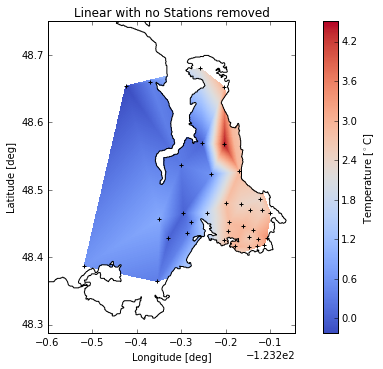

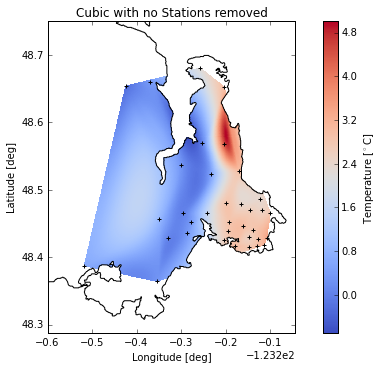

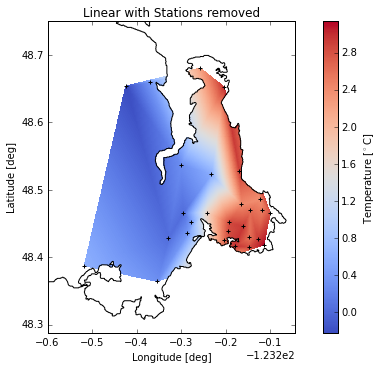

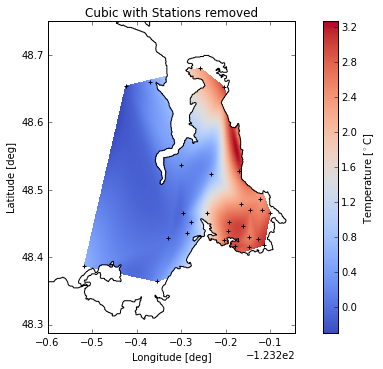

In [104]:
plot2D(lng, lat, cstlng, cstlat, gridx, gridy, zl, mask)
plt.title('Linear with no Stations removed')
plt.show()
plot2D(lng, lat, cstlng, cstlat, gridx, gridy, zc, mask)
plt.title('Cubic with no Stations removed')
plt.show()

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zl2, mask)
plt.title('Linear with Stations removed')
plt.show()
plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zc2, mask)
plt.title('Cubic with Stations removed')
plt.show()

#EOF

In [99]:
temp = np.zeros_like(data3)
for i in range(np.shape(data3)[1]):
    temp[:,i] = data3[:,i] - np.mean(data3[:,i])
np.shape(temp)

C = np.cov(temp)
Cp,E=np.linalg.eig(C)
for i in range(np.shape(E)[1] ):
    ii = np.argmax(np.abs(E[:,i]))
    E[:,i]=E[:,i]/E[ii,i]
E = E/np.max(np.abs(E),axis=0)
yme = np.dot(np.linalg.inv(E), temp) 

44.8926617617


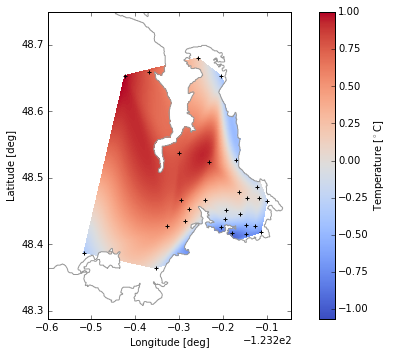

10.9183539389


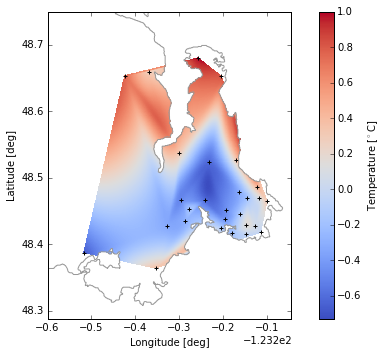

7.06780857091


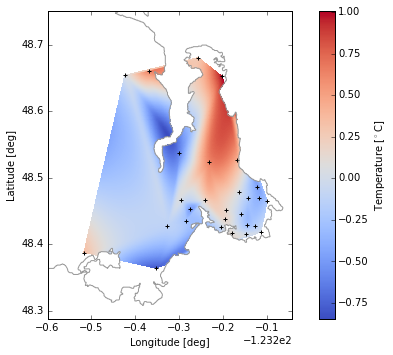

6.45000805289


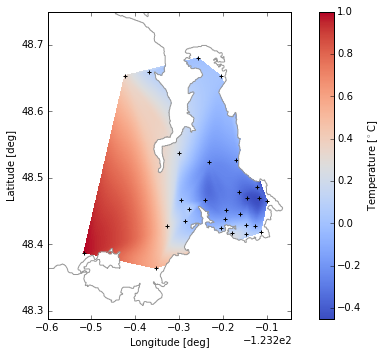

In [100]:
for m in range(4):
    zi = interpolate.griddata(np.vstack((lng2,lat2)).T, E[:,m], (gridx,gridy), method='cubic')
    plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zi, mask)
    print Cp[m]/np.sum(Cp)*100.
    #plt.savefig('figures/hour_mode{}map.png'.format(m))
    plt.show()
    #mode_plot(hours, modes, Cp, start=0, end=-1, m=m)
    #plt.savefig('figures/hour_mode{}ts.png'.format(m))
    #plt.show()

28 28


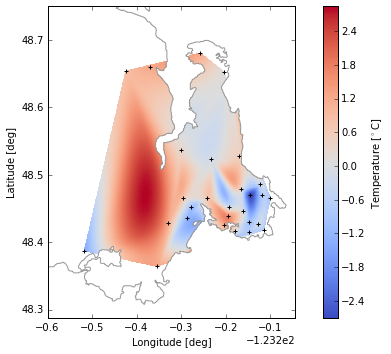

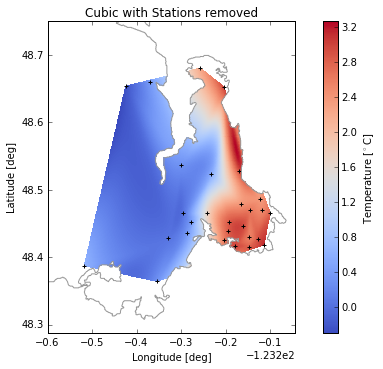

In [14]:
Esum = np.zeros(E[:,0].size)
for ind in range(E[:,0].size):
    Esum[ind] = np.sum(E[ind])
#print E[0]
Esum = (Esum - np.mean(Esum))/np.std(Esum)
print E[:,0].size, Esum.size
zsum = interpolate.griddata(np.vstack((lng2,lat2)).T, Esum, (gridx,gridy), method='cubic')
plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zsum, mask)
plt.show()

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zc2, mask)
plt.title('Cubic with Stations removed')
plt.show()

#Minute Data

In [53]:
# fill in nan values with linear interpolation

def interp(data, rmean=False):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    if rmean:
        data -= np.mean(data)  # remove mean
    return data

dc = interp(dc, rmean=False)
jb = interp(jb, rmean=False)
jm = interp(jm, rmean=False)
uv = interp(uv, rmean=False)

mindata = np.array([dc,jb,jm,uv])
minname = ['Deep Cove', 'James Bay', 'John Muir', 'Uvic']
color = ['#092eb2', '#b3afcc','#8dcc78','#cc1d1f']

['#092eb2', '#b3afcc', '#8dcc78', '#cc1d1f']


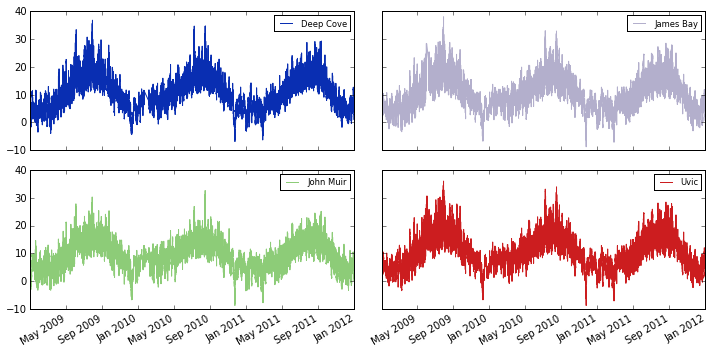

In [80]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))        
ldc = ax[0,0].plot_date(mins, dc, color[0], label=minname[0]) ; ax[0,0].legend(loc='best', fontsize='small')
ljb = ax[0,1].plot_date(mins, jb, color[1], label=minname[1]) ; ax[0,1].legend(loc='best', fontsize='small')
ljm = ax[1,0].plot_date(mins, jm, color[2], label=minname[2]) ; ax[1,0].legend(loc='best', fontsize='small')
luv = ax[1,1].plot_date(mins, uv, color[3], label=minname[3]) ; ax[1,1].legend(loc='best', fontsize='small')


# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
#print fig.axes[:-1]
plt.setp([a.get_xticklabels() for a in fig.axes[:1]], visible=False)

fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/min_timeseries.png')

High-pass filter lets high-frequency (detailed/local information) pass.

Low-pass filter lets low-frequency (coarse/rough/global information) pass.

Thus a low-pass filter is used for the four minute datas since they relay global infromation and to look for yearly patterns and fluxuations rather than daily fluxuations

#Low pass filter
optimization method to find the right amount of days

In [17]:
# ts is minutes in a day, stopband is how many days you want to filter together, also used to optimize the number of days
def lowpass(data, stopband,ts = 60.*24):
    mean = np.mean(data); std = np.std(data)
    value = 0; newmean = 0.; newstd = 0.
    fdata = np.zeros((len(data),len(stopband)))
    for ind in range(len(stopband)):
        df = 1./(stopband[ind]*ts)
        wp = 0.7*df
        ws = 0.9*df
        n, fn = signal.ellipord(wp, ws, 0.5, 20.)
        b, a = signal.ellip(n, 0.5, 20., fn)
        fdata[0:,ind] = signal.lfilter(b, a, data)
        if ind == 0:
            newmean = np.mean(fdata[0:,ind])
            newstd = np.mean(fdata[0:,ind])
        elif ind > 0:
            up = np.abs(np.mean(fdata[0:,ind]) - mean)
            down = np.abs(newmean - mean)
            if up < down:
                value = ind
                newmean = np.mean(fdata[0:,ind])
            elif up == down:
                sup = np.abs(np.std(fdata[0:,ind]) - std)
                sdown = np.abs(newstd - std)
                if sup < down:
                    value = ind
                    newstd = np.std(fdata[0:,ind])
        
    #f = signal.filtfilt(b,a,dc)
    return fdata[0:,value], value

In [18]:
stopband = np.arange(2.,6.,0.1)
fdc, value = lowpass(dc, stopband)
print "DC"
print np.mean(dc),np.mean(fdc), stopband[value], np.std(dc),np.std(fdc)
fjb, value = lowpass(jb, stopband)
print "JB"
print np.mean(jb),np.mean(fjb), stopband[value], np.std(jb),np.std(fjb)
fjm, value = lowpass(jm, stopband)
print "JM"
print np.mean(jm),np.mean(fjm), stopband[value], np.std(jm),np.std(fjm)
fuv, value = lowpass(uv, stopband)
print "UV"
print np.mean(uv),np.mean(fuv), stopband[value], np.std(uv),np.std(fuv)

#print fdc1
#print fdc2
#print "Difference"

DC
10.3016300448 10.3492044253 4.5 5.98099047791 5.33624208742
JB
10.3107251853 10.3575581035 4.5 5.83675368414 5.11853678776
JM
9.11998334356 9.15888456018 4.5 4.8364971532 4.09563407511
UV
10.2371553568 10.2843769125 4.5 5.70055093019 4.99721265829


In [92]:
color2 = ['#92ff19','#005fff','#7540ff','#c7ff40'] 
minname2 = ['Filtered','Filtered', 'Filtered', 'Filtered']
filt = np.array([fdc,fjb,fjm,fuv])

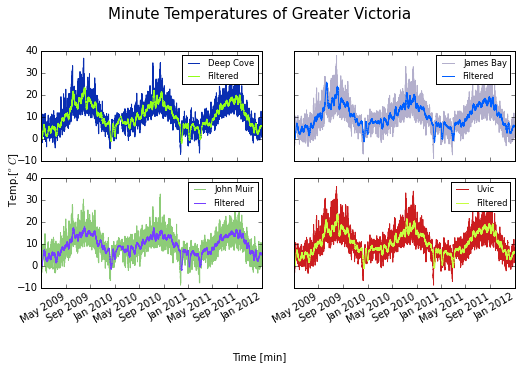

In [93]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))  

ldc = ax[0,0].plot_date(mins, dc, color[0], label=minname[0]) 
lfdc = ax[0,0].plot_date(mins, filt[0], color2[0], label=minname2[0]) ; ax[0,0].legend(loc='upper right', fontsize='small')
ljb = ax[0,1].plot_date(mins, jb, color[1], label=minname[1]) 
lfjb = ax[0,1].plot_date(mins, filt[1], color2[1], label=minname2[1]) ; ax[0,1].legend(loc='upper right', fontsize='small')
ljm = ax[1,0].plot_date(mins, jm, color[2], label=minname[2]) 
lfjm = ax[1,0].plot_date(mins, filt[2], color2[2], label=minname2[2]) ; ax[1,0].legend(loc='upper right', fontsize='small')
luv = ax[1,1].plot_date(mins, uv, color[3], label=minname[3]) 
lfuv = ax[1,1].plot_date(mins, filt[3], color2[3], label=minname2[3]) ; ax[1,1].legend(loc='upper right', fontsize='small')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:1]], visible=False)

fig.text(0.5, 0.0, 'Time [min]', ha='center',fontsize=10)
fig.text(0.15, 0.5, r'Temp.[$^oC$]', va='center', rotation='vertical',fontsize=10)
plt.suptitle('Minute Temperatures of Greater Victoria',fontsize=15)

fig.tight_layout(rect=(0.15,0.01,0.9,0.9))

fig.autofmt_xdate()
#plt.tight_layout()

#Histogram

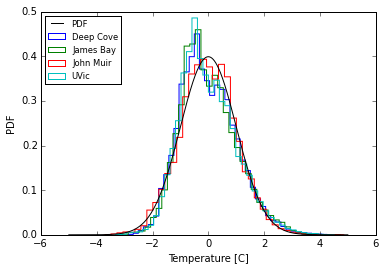

In [26]:
def mean_std(data):
    return (data - np.mean(data))/np.std(data)


bins=40

fig, ax = plt.subplots(1,1)
ax.hist(mean_std(dc), bins, normed=True, histtype='step', label='Deep Cove')
ax.hist(mean_std(jb), bins, normed=True, histtype='step', label='James Bay')
ax.hist(mean_std(jm), bins, normed=True, histtype='step', label='John Muir')
ax.hist(mean_std(uv), bins, normed=True, histtype='step', label='UVic')
x = np.linspace(-5,5,1000)
ax.plot(x,mlab.normpdf(x,0,1),'k',label='PDF')

ax.legend(loc='best',fontsize='small')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('PDF')

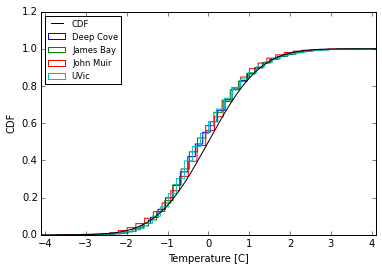

In [98]:
bins=40

fig, ax = plt.subplots(1,1)
ax.hist(mean_std(dc), bins, normed=True, cumulative=True, histtype='step', label='Deep Cove')
ax.hist(mean_std(jb), bins, normed=True, cumulative=True, histtype='step', label='James Bay')
ax.hist(mean_std(jm), bins, normed=True, cumulative=True, histtype='step', label='John Muir')
ax.hist(mean_std(uv), bins, normed=True, cumulative=True, histtype='step', label='UVic')
x = np.linspace(-5,5,1000)
ax.plot(x,stats.norm.cdf(x,0,1),'k',label='CDF')
ax.set_xlim(-4.1,4.1)
ax.legend(loc='best',fontsize='small')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('CDF')
plt.show()

#Power Spectra

In [21]:
Nfft = 2048*12
dt = 60.
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

Pdc, f = mlab.psd(dc, **args)
Pjb, f = mlab.psd(jb, **args)
Pjm, f = mlab.psd(jm, **args)
Puv, f = mlab.psd(uv, **args)

Pdcjb, ff = mlab.csd(dc, jb, **args)
Pjmuv, ff = mlab.csd(jm, uv, **args)
Pdcjm, ff = mlab.csd(dc, jm, **args)
Pdcuv, ff = mlab.csd(dc, uv, **args)
Pjbjm, ff = mlab.csd(jb, jm, **args)
Pjbuv, ff = mlab.csd(jb, uv, **args)

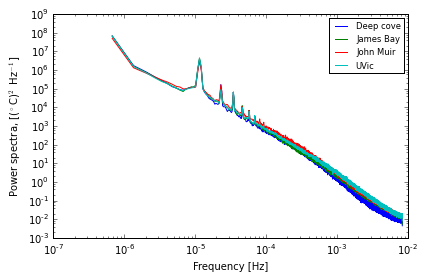

In [22]:
yr = 3600.*24.*365.
day = 3600.*24.
h12 = 3600.*24./2.
h8 = 3600.*24./3.
h6 = 3600.*24./4.

#plt.axvline(1./day, color='k', ls=':')
plt.loglog(f, np.abs(Pdc), label='Deep cove')#, alpha=0.5)
plt.loglog(f, np.abs(Pjb), label='James Bay')#, alpha=0.5)
plt.loglog(f, np.abs(Pjm), label='John Muir')#, alpha=0.5)
plt.loglog(f, np.abs(Puv), label='UVic')#, alpha=0.5)
plt.xlabel('Frequency [Hz]') ; plt.ylabel('Power spectra, [($^\circ$C)$^2$ Hz$^{-1}$]')
plt.legend(loc='best', fontsize='small')

plt.tight_layout()

#Cross Spectral

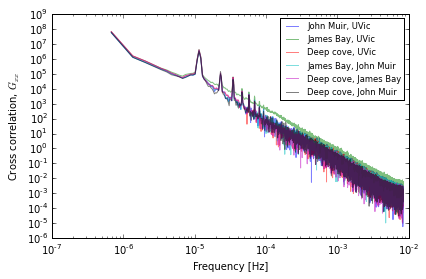

In [23]:
plt.loglog(f, np.abs(Pjmuv), label='John Muir, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbuv), label='James Bay, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pdcuv), label='Deep cove, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbjm), label='James Bay, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pdcjb), label='Deep cove, James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pdcjm), '-k', label='Deep cove, John Muir', alpha=0.5)


plt.xlabel('Frequency [Hz]') ; plt.ylabel('Cross correlation, $G_{xx}$')
plt.legend(loc='best', fontsize='small')

plt.tight_layout()

# Coherence Squared, Phase

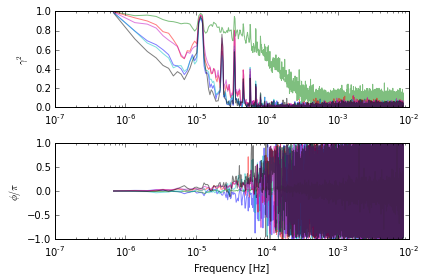

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)#, sharex=True)
ax1.semilogx(f,abs(Pjmuv)**2/Pjm/Puv, label='John Muir, UVic', alpha=0.5)
ax1.semilogx(f,abs(Pjbuv)**2/Pjb/Puv, label='James Bay, UVic', alpha=0.5)
ax1.semilogx(f,abs(Pdcuv)**2/Pdc/Puv, label='Deep Cove, UVic', alpha=0.5)
ax1.semilogx(f,abs(Pjbjm)**2/Pjb/Pjm, label='James Bay, John Muir', alpha=0.5)
ax1.semilogx(f,abs(Pdcjb)**2/Pdc/Pjb, label='Deep Cove, James Bay', alpha=0.5)
ax1.semilogx(f,abs(Pdcjm)**2/Pdc/Pjm,'-k', label='Deep Cove, John Muir', alpha=0.5)

ax1.set_ylabel(r'$\gamma^2$')
#plt.legend(loc='best', fontsize='small')

ax2.semilogx(f,np.angle(Pjmuv)/np.pi, label='John Muir, UVic', alpha=0.5)
ax2.semilogx(f,np.angle(Pjbuv)/np.pi, label='James Bay, UVic', alpha=0.5)
ax2.semilogx(f,np.angle(Pdcuv)/np.pi, label='Deep Cove, UVic', alpha=0.5)
ax2.semilogx(f,np.angle(Pjbjm)/np.pi, label='James Bay, John Muir', alpha=0.5)
ax2.semilogx(f,np.angle(Pdcjb)/np.pi, label='Deep Cove, James Bay', alpha=0.5)
ax2.semilogx(f,np.angle(Pdcjm)/np.pi,'-k', label='Deep Cove, John Muir', alpha=0.5)

ax2.set_xlabel('Frequency [Hz]') ; ax2.set_ylabel('$\phi / \pi$')
#plt.legend(loc='best', fontsize='small')

plt.tight_layout()